# Recycling Labs Framework From Libs

In [51]:
from src.preprocessing import clean_func, spacy_preprocess_reviews
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os

INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]


## STS Analyzer

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import src.config as config
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train_model_cv(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
    print("CV Scores:", cv_score)

    acc_mean = cv_score.mean()
    acc_std = cv_score.std()
    print(f"CV Score: {acc_mean:.4f}+-{acc_std:.4f}")

    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", acc_val)

    # Predict
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc_test)
    return model, acc_mean, acc_val, acc_test


def train_extracted_features(MODEL_NAME):
    INPUT_PATH = config.OUTPUT_FEATEXT_DATA

    TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
    TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
    VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
    VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
    TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
    TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

    X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
    X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
    X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

    ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]

    sc = StandardScaler()
    X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
    X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
    X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

    xgb = XGBClassifier(n_jobs=-1, **{'eta': 0.25,
                                        'gamma': 0.006,
                                        'max_depth': 3,
                                        'reg_lambda': 3.1})
    
    lsvm = LinearSVC(dual='auto')
    svm = SVC(random_state=0, **{'C': 4.5, 'gamma': 0.003})
    
    rf = RandomForestClassifier(n_jobs=-1, random_state=0, **{'ccp_alpha': 0.001,
                                                              'min_samples_leaf': 2,
                                                              'n_estimators': 110})
    vc = VotingClassifier(estimators=[('xgb', xgb), ('lsvm', lsvm), 
                                      ('svm', svm), ('rf', rf)], 
                          voting='hard', n_jobs=-1)

    ls_models = [xgb, lsvm, svm, rf, vc]
    d_results = {}
    for model in ls_models:
        print("Model:", model.__class__.__name__)
        model, acc_mean, acc_val, acc_test = train_model_cv(model, X_train_prep, y_train, 
                                                            X_valid_prep, y_valid, X_test_prep, y_test)
        d_results[model.__class__.__name__] = {'model_name': model.__class__.__name__, 
                                               'trained_model': model, 'CV_accuracy': acc_mean,
                                                'val_accuracy': acc_val, 'test_accuracy': acc_test}
        
    return d_results

model_names = ["EfficientNetB3", "FineTunedVGG16"]

df_model_comp = pd.DataFrame()
for model_name in model_names:
    print("Model:", model_name)
    d_ex = train_extracted_features(model_name)
    df_ = pd.DataFrame(d_ex).T
    df_["extractor"] = model_name
    df_model_comp = pd.concat([df_model_comp, df_], ignore_index=True)

df_model_comp

In [80]:
def dice_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    return 2*len(x_n_y) / (len(x) + len(y))

def overlap_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return len(x_n_y) / min(len(x), len(y))
    except ZeroDivisionError:
        return 0

def cosine_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)

    if len(x_n_y) == 0:
        return 0
    
    try:
        return len(x_n_y) / np.sqrt(len(x)*len(y))
    except ZeroDivisionError:
        return 0

def jaccard_sim(x, y):
    '''
    Get the Jaccard similarity between two sets
    '''
    x = set(x)
    y = set(y)
    return 1 - jaccard_distance(x, y)

In [91]:
sts = STSAnalyzer(preprocess_fun=lambda x: spacy_preprocess_reviews(x, clean_func=clean_func), 
                  model=BaselineModel(strategy="constant", constant=0), 
                  name='Baseline (Constant 0)',
                  input_path=TRAIN_PATH,
                  ls_files=LS_FILES_TRAIN,
                  )
sts_test = STSAnalyzer(preprocess_fun=lambda x: spacy_preprocess_reviews(x, clean_func=clean_func), 
                        model=BaselineModel(strategy="constant", constant=0), 
                        name='Baseline (Constant 0)',
                        )

In [92]:
df_sample = sts.load_data()
df_sample["sent1"] = df_sample["sent1"].apply(sts.preprocess_fun)
df_sample["sent2"] = df_sample["sent2"].apply(sts.preprocess_fun)

df_sample_test = sts_test.load_data()
df_sample_test["sent1"] = df_sample_test["sent1"].apply(sts.preprocess_fun)
df_sample_test["sent2"] = df_sample_test["sent2"].apply(sts.preprocess_fun)

df_sample

,sent1,sent2,gs,file
0,"[source, close, sale, say, vivendi, keep, door...","[source, close, sale, say, vivendi, keep, door...",4.00,MSRpar
1,"[micron, declare, quarterly, profit, year]","[micron, number, mark, quarterly, profit, year...",3.75,MSRpar
2,"[fine, fail, republican, effort, force, entice...","[perry, say, back, senate, effort, include, fi...",2.80,MSRpar
3,"[american, anglican, council, represent, episc...","[american, anglican, council, represent, episc...",3.40,MSRpar
4,"[tech, load, nasdaq, composite, rise, 20.96, p...","[technology, lace, nasdaq, composite, index, i...",2.40,MSRpar
...,...,...,...,...
2229,"[action, need, quickly, decide, include, item,...","[urgent, decide, item, agenda]",5.00,SMTeuroparl
2230,"[wish, improvement, honestly, believe, good, s...","[actually, want, well, think, honestly, good, ...",4.80,SMTeuroparl
2231,"[parliament, accept, oral, amendment]","[parliament, accept, oral, amendment]",5.00,SMTeuroparl
2232,"[party, reservation, community, law, apply, sa...","[party, reservation, regulation, sale, consump...",4.80,SMTeuroparl


In [93]:
df_feats = df_sample[["sent1", "sent2"]].copy()

d_similarities = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}

for name, sim in d_similarities.items():
    df_feats[name] = df_feats.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)

df_feats_test = df_sample_test[["sent1", "sent2"]].copy()

for name, sim in d_similarities.items():
    print(name)
    df_feats_test[name] = df_feats_test.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)


df_feats

jaccard
dice
overlap
cosine


,sent1,sent2,jaccard,dice,overlap,cosine
0,"[source, close, sale, say, vivendi, keep, door...","[source, close, sale, say, vivendi, keep, door...",0.562500,0.720000,0.900000,0.734847
1,"[micron, declare, quarterly, profit, year]","[micron, number, mark, quarterly, profit, year...",0.444444,0.615385,0.800000,0.632456
2,"[fine, fail, republican, effort, force, entice...","[perry, say, back, senate, effort, include, fi...",0.384615,0.555556,0.625000,0.559017
3,"[american, anglican, council, represent, episc...","[american, anglican, council, represent, episc...",0.647059,0.785714,0.916667,0.793857
4,"[tech, load, nasdaq, composite, rise, 20.96, p...","[technology, lace, nasdaq, composite, index, i...",0.142857,0.250000,0.272727,0.250873
...,...,...,...,...,...,...
2229,"[action, need, quickly, decide, include, item,...","[urgent, decide, item, agenda]",0.375000,0.545455,0.750000,0.566947
2230,"[wish, improvement, honestly, believe, good, s...","[actually, want, well, think, honestly, good, ...",0.300000,0.461538,0.500000,0.462910
2231,"[parliament, accept, oral, amendment]","[parliament, accept, oral, amendment]",1.000000,1.000000,1.000000,1.000000
2232,"[party, reservation, community, law, apply, sa...","[party, reservation, regulation, sale, consump...",0.500000,0.666667,0.666667,0.666667


In [94]:
df_train = df_feats.iloc[:, 2:]
y_train = df_sample["gs"]

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

sc = StandardScaler()
lasso = LassoCV(cv = 5, random_state = 0, max_iter = 10000, alphas=[0.01, 0.1, 1, 10, 100],
                fit_intercept=False)

X_train = df_train.copy()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
lasso.fit(X_train_sc, y_train)

lasso.coef_

array([0.       , 0.8822271, 0.       , 0.       ])

In [95]:
lasso.intercept_

0.0

In [96]:
X_test = df_feats_test.iloc[:, 2:]
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
y_test = df_sample_test["gs"]

y_pred = lasso.predict(X_test_sc)

from scipy.stats import pearsonr

rms = pearsonr(y_test, y_pred).statistic
rms

0.635376513615439

In [97]:
sts_test_lasso = STSAnalyzer(preprocess_fun=lambda x: spacy_preprocess_reviews(x, clean_func=clean_func), 
                                model=lasso, 
                                name='Lasso',
                                )

sts_test_lasso.load_data()
sts_test_lasso.get_results()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sent1
- sent2
Feature names seen at fit time, yet now missing:
- cosine
- dice
- jaccard
- overlap


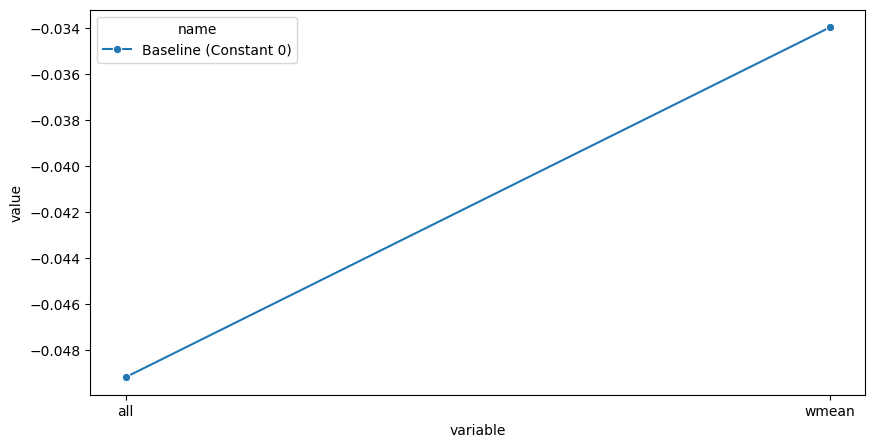

In [5]:
sts = STSAnalyzer(preprocess_fun=spacy_preprocess_reviews, 
                  model=BaselineModel(strategy="constant", constant=0), 
                  name='Baseline (Constant 0)')

sts.load_data(ls_files=STSAnalyzer.LS_FILES_TEST)
sts.get_results()
sts.plot_col_analysis()